In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *
from zipfile import ZipFile

In [2]:
%matplotlib inline

In [3]:
myfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/river_floods/"

# Undiscounted

Note that the name of the columns contain a discount rate but according to Philip Ward this is undiscounted.

In [195]:
undiscounted = pd.DataFrame()
for myfilename in os.listdir(myfolder+"output_undiscounted\\"):
    if myfilename.endswith('.csv'):
        temp = pd.read_csv(myfolder+"output_undiscounted\\"+myfilename).set_index("ID")
        myinfo = myfilename.replace(".csv",'').split("_")
        temp = temp[["C_5pc_high","C_5pc_middle","C_5pc_low"]].rename(columns={"C_5pc_high":"high","C_5pc_middle":"middle","C_5pc_low":"low"})
        temp.columns.name = "construction_cost"
        temp = temp.stack().reset_index()
        temp["objective"] = myinfo[0]
        temp["gcm"] = myinfo[1]
        temp["rcp"] = myinfo[2]
        temp["ssp"] = myinfo[3]
        temp["current_std"] = "middle"
        temp = temp.set_index(["ID","construction_cost","objective","gcm","rcp","ssp","current_std"]).rename(columns={0:"infra_cost"})
        undiscounted = undiscounted.append(temp)

In [196]:
undiscounted

infra_cost
ID   construction_cost objective gcm       rcp    ssp  current_std              
1    high              car       gfdlesm2m rcp2p6 ssp1 middle       1.364626e+10
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       4.548754e+09
     low               car       gfdlesm2m rcp2p6 ssp1 middle       1.516251e+09
2    high              car       gfdlesm2m rcp2p6 ssp1 middle       1.132865e+10
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       3.776218e+09
     low               car       gfdlesm2m rcp2p6 ssp1 middle       1.258739e+09
3    high              car       gfdlesm2m rcp2p6 ssp1 middle       1.087388e+10
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       3.624626e+09
     low               car       gfdlesm2m rcp2p6 ssp1 middle       1.208209e+09
4    high              car       gfdlesm2m rcp2p6 ssp1 middle       1.311870e+10
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       4.372901e+09
     low               car       gfdlesm2m rcp2p6 ssp1 middle       1.457634e+09
5    high              car       gfdlesm2m rcp2p6 ssp1 middle       1.999193e+09
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       6.663976e+08
     low               car       gfdlesm2m rcp2p6 ssp1 middle       2.221325e+08
6    high              car       gfdlesm2m rcp2p6 ssp1 middle       1.782750e+10
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       5.942499e+09
     low               car       gfdlesm2m rcp2p6 ssp1 middle       1.980833e+09
7    high              car       gfdlesm2m rcp2p6 ssp1 middle       3.000340e+09
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       1.000113e+09
     low               car       gfdlesm2m rcp2p6 ssp1 middle       3.333711e+08
8    high              car       gfdlesm2m rcp2p6 ssp1 middle       1.234416e+10
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       4.114721e+09
     low               car       gfdlesm2m rcp2p6 ssp1 middle       1.371574e+09
9    high              car       gfdlesm2m rcp2p6 ssp1 middle       3.165269e+09
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       1.055090e+09
     low               car       gfdlesm2m rcp2p6 ssp1 middle       3.516966e+08
10   high              car       gfdlesm2m rcp2p6 ssp1 middle       2.450506e+10
     middle            car       gfdlesm2m rcp2p6 ssp1 middle       8.168353e+09
     low               car       gfdlesm2m rcp2p6 ssp1 middle       2.722784e+09
...                                                                          ...
4636 high              opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     middle            opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     low               opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
4637 high              opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     middle            opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     low               opt       noresm1m  rcp8p5 ssp5 middle       1.340357e+09
4638 high              opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     middle            opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     low               opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
4639 high              opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     middle            opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     low               opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
4640 high              opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     middle            opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     low               opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
4641 high              opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     middle            opt       noresm1m  rcp8p5 ssp5 middle       0.000000e+00
     low            

In [23]:
countries = pd.read_excel(myfolder+"State_names_Countries.xlsx")

In [202]:
gdp = pd.read_excel(myfolder+"GDP_Julie.xlsx")

In [203]:
gdp.columns

Index([        'FID',          2010,  'Unnamed: 2', 'SSP1 - 2030',
       'SSP2 - 2030', 'SSP3 - 2030', 'SSP4 - 2030', 'SSP5 - 2030',
        'Unnamed: 8', 'SSP1 - 2050', 'SSP2 - 2050', 'SSP3 - 2050',
       'SSP4 - 2050', 'SSP5 - 2050', 'Unnamed: 14', 'SSP1 - 2080',
       'SSP2 - 2080', 'SSP3 - 2080', 'SSP4 - 2080', 'SSP5 - 2080'],
      dtype='object')

In [214]:
gdp_2030 = gdp[["FID",'SSP1 - 2030', 'SSP2 - 2030', 'SSP3 - 2030', 'SSP4 - 2030','SSP5 - 2030']].rename(columns={'SSP1 - 2030':"ssp1",\
                                                                                                            'SSP2 - 2030':"ssp2",\
                                                                                                            'SSP3 - 2030':"ssp3",\
                                                                                                            'SSP4 - 2030':"ssp4",\
                                                                                                            'SSP5 - 2030':"ssp5"})

gdp_2030 = gdp_2030.set_index("FID")
gdp_2030.columns.name="ssp"
gdp_2030 = gdp_2030.stack()

gdp_2030 = gdp_2030.reset_index().rename(columns={0:2030})

In [215]:
gdp_2050 = gdp[["FID",'SSP1 - 2050', 'SSP2 - 2050', 'SSP3 - 2050', 'SSP4 - 2050','SSP5 - 2050']].rename(columns={'SSP1 - 2050':"ssp1",\
                                                                                                            'SSP2 - 2050':"ssp2",\
                                                                                                            'SSP3 - 2050':"ssp3",\
                                                                                                            'SSP4 - 2050':"ssp4",\
                                                                                                            'SSP5 - 2050':"ssp5"})

gdp_2050 = gdp_2050.set_index("FID")
gdp_2050.columns.name="ssp"
gdp_2050 = gdp_2050.stack()

gdp_2050 = gdp_2050.reset_index().rename(columns={0:2050})

In [218]:
gdp_all_years = gdp_2030.merge(gdp_2050,on=["FID","ssp"],how="outer").merge(gdp[["FID",2010]],on="FID",how="outer")

In [220]:
gdp_all_years = gdp_all_years.set_index(["FID","ssp"])
gdp_all_years.columns.name="year"
gdp_all_years = gdp_all_years.stack()

In [223]:
gdp_all_years = gdp_all_years.reset_index().rename(columns={0:'gdp'})

In [228]:
gdp_all_years = gdp_all_years.set_index(["FID","ssp","year"]).sort_index(level=["FID","ssp","year"])

In [258]:
test = gdp_all_years.unstack(level=["FID","ssp"]).reindex(range(2010,2051))

In [260]:
new_gdp = test.interpolate(axis=0)

In [274]:
final_annual_gdp = new_gdp.unstack().reset_index().drop("level_0",axis=1).rename(columns={0:"gdp"})

In [267]:
final_annual_gdp.sample(3)

,FID,ssp,year,gdp
223317,1089,ssp2,2041,1.900189e+10
327508,1597,ssp4,2010,3.628686e+08
799305,3899,ssp1,2020,0.000000e+00


In [275]:
final_annual_gdp = final_annual_gdp.merge(countries,on="FID",how="left")

In [277]:
final_annual_gdp = final_annual_gdp.set_index(["FID","Country name","ssp","year"]).gdp.sum(level=["Country name","ssp","year"])

In [270]:
codes = pd.read_csv(myfolder+"wbccodes2014.csv")

In [197]:
undiscounted = undiscounted.dropna().reset_index()

In [198]:
undiscounted = undiscounted.merge(countries.rename(columns={"FID":"ID"}),on="ID",how="left")

In [199]:
undiscounted_c = undiscounted.set_index(["ID","Country name","construction_cost","objective","gcm","rcp","ssp","current_std"]).sum(level=["Country name","construction_cost","objective","gcm","rcp","ssp","current_std"])

In [200]:
undiscounted_c = undiscounted_c.reset_index().rename(columns={"Country name":"country_name"}).merge(codes,on="country_name",how="left")

In [201]:
newfile = undiscounted_c.set_index(["wbregionname","country_name","construction_cost","objective","gcm","rcp","ssp","current_std"]).infra_cost.sum(level=["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std"])

In [278]:
final_annual_gdp = final_annual_gdp.reset_index().rename(columns={"Country name":"country_name"}).merge(codes,on="country_name",how="left")

In [279]:
gdp_reg = final_annual_gdp.set_index(["wbregionname","ssp","country_name","year"]).gdp.sum(level=["wbregionname","ssp","year"])

In [281]:
newfile = newfile.reset_index().merge(gdp_reg.reset_index(),on=["wbregionname","ssp"])

In [283]:
newfile["annual_cost"] = newfile.infra_cost/30

In [284]:
newfile.loc[newfile.year<2021,"annual_cost"] = 0
newfile.loc[newfile.year>2050,"annual_cost"] = 0

In [297]:
newfile = newfile.set_index(["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std","year"])

In [298]:
newfile["cumcost"] = newfile.annual_cost.unstack("year").cumsum(axis=1).stack("year")

In [300]:
newfile["maintenance_cost"] = 1/100*newfile["cumcost"]

In [301]:
newfile["total_annual_cost"] = newfile["annual_cost"]+newfile["maintenance_cost"]

In [348]:
all_dev = newfile.drop("High Income", level="wbregionname").sum(level=["construction_cost","objective","gcm","rcp","ssp","current_std","year"])

In [349]:
all_dev["total_annual_cost_pc"] = all_dev.total_annual_cost/all_dev.gdp
all_dev["annual_cost_pc"]       = all_dev.annual_cost/all_dev.gdp
all_dev["maintenance_cost_pc"]  = all_dev.maintenance_cost/all_dev.gdp

In [303]:
newfile["total_annual_cost_pc"] = newfile.total_annual_cost/newfile.gdp
newfile["annual_cost_pc"]       = newfile.annual_cost/newfile.gdp
newfile["maintenance_cost_pc"]  = newfile.maintenance_cost/newfile.gdp

In [383]:
test = all_dev[["total_annual_cost_pc"]].reset_index().copy()
test = test.loc[(test.year>2014)&(test.year<2051)]
test = test.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
test = test.reset_index()
test["total_annual_cost_pc"] = 100*test["total_annual_cost_pc"]
test["objective"] = test.objective.replace({"car":"Constant absolute risk","crr":"Constant relative risk","opt":"Cost minimization"})

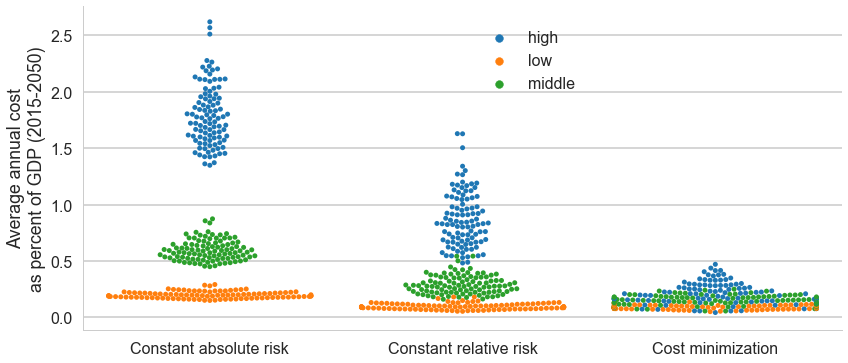

In [384]:
g = sns.factorplot(x='objective',y='total_annual_cost_pc', hue= 'construction_cost', data=test, kind="swarm",dodge=False, size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Average annual cost\nas percent of GDP (2015-2050)")
g.add_legend(title="",bbox_to_anchor=(0.6, 0.7), borderaxespad=0.)

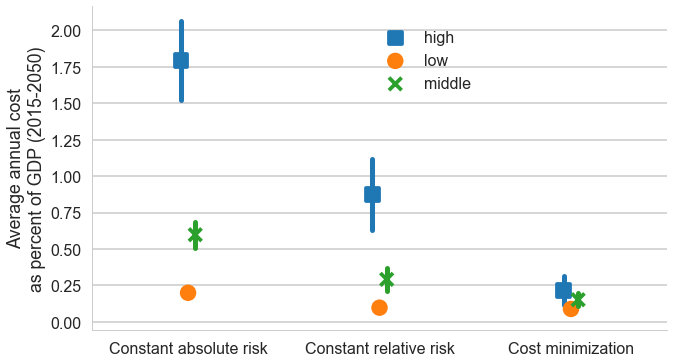

In [386]:
g = sns.factorplot(x='objective',y='total_annual_cost_pc', hue= 'construction_cost', data=test, kind="point",dodge=True,join=False,\
                  ci='sd', markers=["s",'o','x'], size=6, aspect=1.6,\
                  legend=False)

g.set_axis_labels("", "Average annual cost\nas percent of GDP (2015-2050)")
g.add_legend(title="",bbox_to_anchor=(0.6, 0.7), borderaxespad=0.)

In [382]:
test = all_dev[["total_annual_cost_pc"]].reset_index().copy()
test = test.loc[(test.year>2014)&(test.year<2051)]
test = test.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
test = test.reset_index()

In [365]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [366]:
def drivers_from_anova(varin,mydata):
    formula=varin+" ~ construction_cost+objective+gcm+rcp+ssp+current_std"
    olsmodel=ols(formula,data=mydata).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
    table=table.sort_values(by=['sum_sq'],ascending=False)
    sumvar=0
    drivers=list()
    for var in table.index:
        if var!='Residual':
            drivers.append(var)
            sumvar+=table.loc[var,'sum_sq_pc']
        if len(drivers)==3:
            break
    return drivers,sumvar

In [370]:
drivers,sumvar = drivers_from_anova("total_annual_cost_pc",test)
print(drivers,sumvar)

['construction_cost', 'objective', 'gcm'] 0.726689656245


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [371]:
test.construction_cost.unique()

array(['high', 'low', 'middle'], dtype=object)

In [322]:
toplot = newfile.reset_index().copy()
toplot = toplot.loc[(toplot.year>2014)&(toplot.year<2051)&(toplot.wbregionname!="High Income"),:]
toplot = toplot.set_index(["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std"])
toplot = toplot.reset_index()
toplot['total_annual_cost_pc'] = 100*toplot.total_annual_cost_pc
toplot['maintenance_cost_pc'] = 100*toplot.maintenance_cost_pc
toplot['annual_cost_pc'] = 100*toplot.annual_cost_pc
toplot["wbregionname"] = toplot.wbregionname.str.replace(" ","\n")
toplot["objective"] = toplot.objective.replace({"car":"Constant absolute risk","crr":"Constant relative risk","opt":"Cost minimization"})

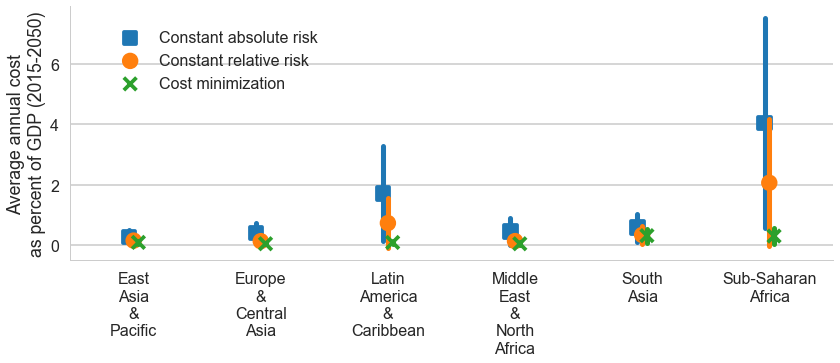

In [323]:
g = sns.factorplot(x='wbregionname',y='annual_cost_pc', hue= 'objective', data=toplot, kind="point",dodge=True,join=False,\
                  ci='sd', markers=["s",'o','x'], size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Average annual cost\nas percent of GDP (2015-2050)")
g.add_legend(title="",bbox_to_anchor=(0.3, 0.7), borderaxespad=0.)

In [343]:
toplot = newfile.reset_index().copy()
toplot = toplot.loc[(toplot.year>2014)&(toplot.year<2031)&(toplot.wbregionname!="High Income")&(toplot.objective=="opt")&((toplot.ssp=='ssp5')|(toplot.ssp=='ssp3')),:]
toplot = toplot.set_index(["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std"])
toplot = toplot.reset_index()
toplot['total_annual_cost_pc'] = 100*toplot.total_annual_cost_pc
toplot['maintenance_cost_pc'] = 100*toplot.maintenance_cost_pc
toplot['annual_cost_pc'] = 100*toplot.annual_cost_pc
toplot["wbregionname"] = toplot.wbregionname.str.replace(" ","\n")
toplot["objective"] = toplot.objective.replace({"car":"Constant absolute risk","crr":"Constant relative risk","opt":"Cost minimization"})
toplot["ssp"] = toplot.ssp.replace({"ssp3":"Slow economic growth and urbanization","ssp5":"Fast economic growth and urbanization"})

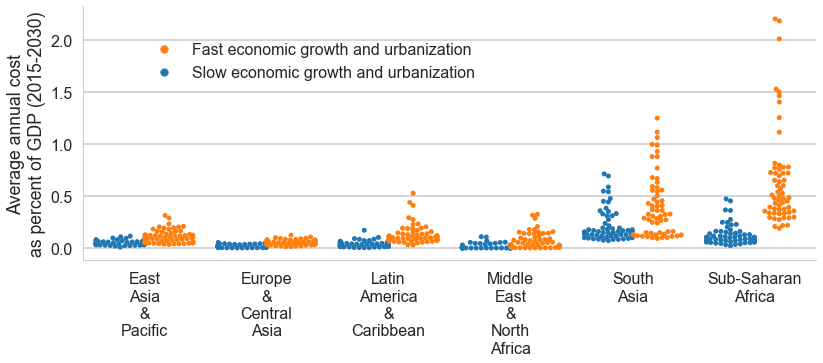

In [347]:
g = sns.factorplot(x='wbregionname',y='annual_cost_pc', hue= 'ssp', data=toplot, kind="swarm",dodge=True,\
                  size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Average annual cost\nas percent of GDP (2015-2030)")
g.add_legend(title="",bbox_to_anchor=(0.4, 0.7), borderaxespad=0.)

#plt.savefig("riverine_protection_cost_pc_gdp.png",ddpi=300,bbox_inches="tight")

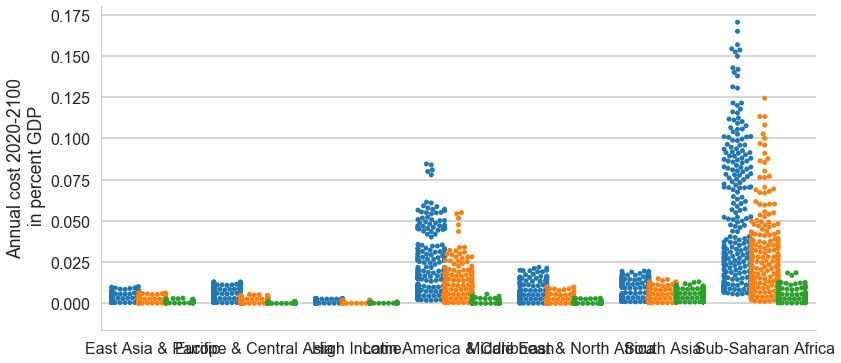

In [315]:
g = sns.factorplot(x='wbregionname',y='total_annual_cost_pc',hue= 'objective', data=toplot, kind="swarm",dodge=True, size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Annual cost 2020-2100\n in percent GDP")

# Discounted

In [6]:
zip_file = ZipFile(myfolder+'results_constant_absolute_risk_FLOPROS.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [18]:
for myfilename in os.listdir(myfolder):
    if myfilename.endswith('.zip'):
        if "half" in myfilename:
            print(myfilename)

results_constant_absolute_risk_FLOPROS_half.zip
results_constant_relative_risk_FLOPROS_half.zip
results_optimise_FLOPROS_half.zip


In [19]:
bigfile = pd.DataFrame()
for myfilename in os.listdir(myfolder):
    if myfilename.endswith('.zip'):
        zip_file = ZipFile(myfolder+myfilename)
        for text_file in zip_file.infolist():
            if text_file.filename.endswith('.csv'):
                temp = pd.read_csv(zip_file.open(text_file.filename)).set_index("ID")
                myinfo = text_file.filename.replace(".csv",'').split("_")
                temp = temp[["C_5pc_high","C_5pc_middle","C_5pc_low"]].rename(columns={"C_5pc_high":"high","C_5pc_middle":"middle","C_5pc_low":"low"})
                temp.columns.name = "construction_cost"
                temp = temp.stack().reset_index()
                temp["objective"] = myinfo[0]
                temp["gcm"] = myinfo[1]
                temp["rcp"] = myinfo[2]
                temp["ssp"] = myinfo[3]
                if "half" in myfilename:
                    temp["current_std"] = "half"
                elif "double" in myfilename:
                    temp["current_std"] = "double"
                else:
                    temp["current_std"] = "middle"
                temp = temp.set_index(["ID","construction_cost","objective","gcm","rcp","ssp","current_std"]).rename(columns={0:"infra_cost"})
                bigfile = bigfile.append(temp)

In [20]:
bigfile.to_csv(myfolder+"cleaned_data.csv")

In [ ]:
bigfile = pd.read_csv(myfolder+"cleaned_data.csv").set_index(["ID","construction_cost","objective","gcm","rcp","ssp","current_std"]

In [24]:
bigfile = bigfile.dropna().reset_index()

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'int64'

In [30]:
bigfile = bigfile.merge(countries.rename(columns={"FID":"ID"}),on="ID",how="left")

In [34]:
mediumfile = bigfile.set_index(["ID","Country name","construction_cost","objective","gcm","rcp","ssp","current_std"]).sum(level=["Country name","construction_cost","objective","gcm","rcp","ssp","current_std"])

In [36]:
mediumfile.to_csv(myfolder+"country_data.csv")

In [181]:
newfile = mediumfile.reset_index().rename(columns={"Country name":"country_name"}).merge(codes,on="country_name",how="left")

In [182]:
newfile = newfile.set_index(["wbregionname","country_name","construction_cost","objective","gcm","rcp","ssp","current_std"]).infra_cost.sum(level=["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std"])

In [101]:
newfile.reset_index().ssp.unique()

array(['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5'], dtype=object)

In [151]:
for reg,subframe in newfile.groupby(level='wbregionname'):
    drivers,sumvar = drivers_from_anova("infra_cost",subframe.reset_index())
    print(reg,drivers,sumvar)

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


East Asia & Pacific ['construction_cost', 'objective', 'rcp'] 0.687949322328
Europe & Central Asia ['objective', 'construction_cost', 'gcm'] 0.624434955697
High Income ['construction_cost', 'objective', 'gcm'] 0.676828444508
Latin America & Caribbean ['objective', 'construction_cost', 'gcm'] 0.622763025349
Middle East & North Africa ['objective', 'construction_cost', 'gcm'] 0.548318644411
South Asia ['construction_cost', 'objective', 'gcm'] 0.776165915531
Sub-Saharan Africa ['objective', 'construction_cost', 'gcm'] 0.685807895444


In [183]:
all_dev = newfile.drop("High Income",level="wbregionname").sum(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])

In [184]:
all_dev = all_dev.reset_index().merge(gdp_reg.drop("High Income",level="wbregionname").sum(level="ssp").reset_index(),on=["ssp"])

In [185]:
all_dev["cost_pc_gdp"] = 1/80*all_dev.infra_cost/all_dev.gdp

In [186]:
newfile = newfile.reset_index().merge(gdp_reg.reset_index(),on=["wbregionname","ssp"])

In [187]:
newfile["cost_pc_gdp"] = 1/80*newfile.infra_cost/newfile.gdp

In [188]:
100*newfile["cost_pc_gdp"].describe()

count    1.680000e+06
mean     2.011647e-01
std      4.980375e-01
min      0.000000e+00
25%      1.471012e-02
50%      4.291304e-02
75%      1.510726e-01
max      5.244726e+00
Name: cost_pc_gdp, dtype: float64

In [55]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [165]:
toplot = newfile.loc[(newfile.construction_cost=="middle")&(newfile.wbregionname!="High Income"),:].copy()
toplot['cost_pc_gdp'] = 100*toplot.cost_pc_gdp
toplot["wbregionname"] = toplot.wbregionname.str.replace(" ","\n")
toplot["objective"] = toplot.objective.replace({"car":"Constant absolute risk","crr":"Constant relative risk","opt":"Cost minimization"})

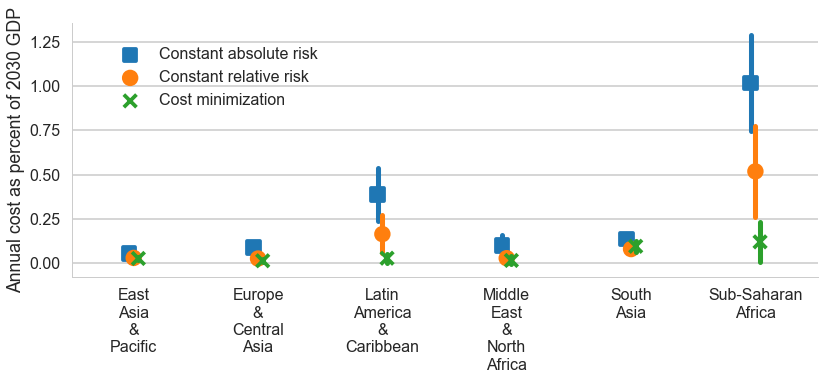

In [167]:
g = sns.factorplot(x='wbregionname',y='cost_pc_gdp', hue= 'objective', data=toplot, kind="point",dodge=True,join=False,\
                  ci='sd', markers=["s",'o','x'], size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Annual cost as percent of 2030 GDP")
g.add_legend(title="",bbox_to_anchor=(0.3, 0.7), borderaxespad=0.)

In [189]:
toplot = all_dev.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std"]).drop(["low","high"],level="construction_cost").reset_index()
toplot["infra_cost"] = 10**(-9)*toplot["infra_cost"]/80
toplot["objective"] = toplot.objective.replace({"car":"Constant\nabsolute risk","crr":"Constant\nrelative risk","opt":"Cost minimization"})

toplot['cost_pc_gdp'] = 100*toplot.cost_pc_gdp

toplot = toplot.set_index("objective").sort_index(level="objective")
toplot = toplot.reset_index()

In [190]:
drivers,sumvar = drivers_from_anova("cost_pc_gdp",toplot)
print(drivers,sumvar)

['objective', 'gcm', 'rcp'] 0.942017663541


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


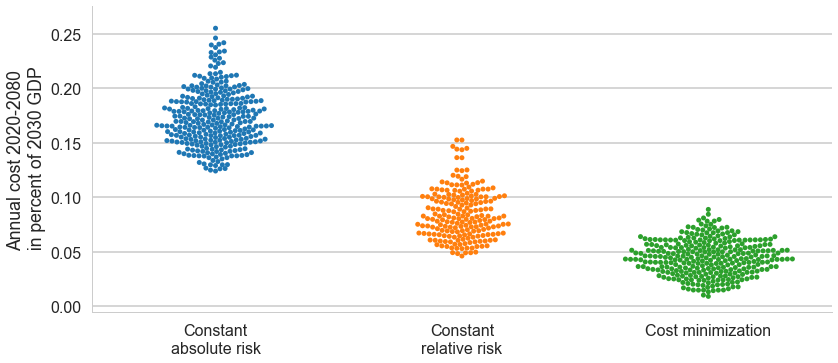

In [192]:
g = sns.factorplot(x='objective',y='cost_pc_gdp', data=toplot, kind="swarm",dodge=False, size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Annual cost 2020-2080\n in percent of 2030 GDP")
#g.add_legend(title="Construction cost",bbox_to_anchor=(0.8, 0.6), borderaxespad=0.)



In [85]:
toplot = all_dev.reset_index()
toplot["infra_cost"] = 10**(-9)*toplot["infra_cost"]/80
toplot["objective"] = toplot.objective.replace({"car":"Constant\nabsolute risk","crr":"Constant\nrelative risk","opt":"Cost minimization"})

#toplot = toplot.set_index("objective").sort_index(level="objective")
#toplot = toplot.reset_index()

toplot["construction_cost"] = toplot.construction_cost.replace({"low":"Clow","middle":"Bmedium","high":"Ahigh"})
toplot = toplot.set_index(["construction_cost","objective"]).sort_index(level=["construction_cost","objective"])
toplot = toplot.reset_index()

toplot["construction_cost"] = toplot.construction_cost.apply(lambda x : x[1:])

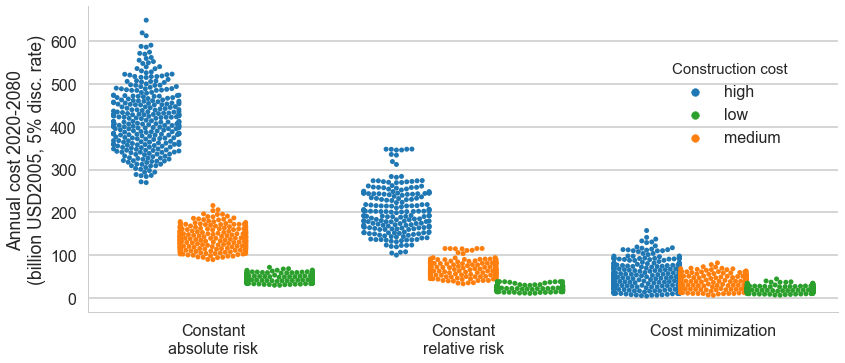

In [89]:
g = sns.factorplot(x='objective',y='infra_cost', hue= 'construction_cost', data=toplot, kind="swarm",dodge=True, size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Annual cost 2020-2080\n(billion USD2005, 5% disc. rate)")
g.add_legend(title="Construction cost",bbox_to_anchor=(0.8, 0.6), borderaxespad=0.)

plt.savefig("riverine_protection.png",ddpi=300,bbox_inches="tight")
plt.savefig("riverine_protection.pdf")